In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
from collections import Counter

data_dir = '../../data/'

In [56]:
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])

# convert the data column to a value that can be used for machine learning
data['PROF_DATE_TIME_LOCAL'] = pd.to_datetime(data['PROF_DATE_TIME_LOCAL'], utc=True)
data['year'] = data['PROF_DATE_TIME_LOCAL'].dt.year
data['month'] = data['PROF_DATE_TIME_LOCAL'].dt.month
data['day'] = data['PROF_DATE_TIME_LOCAL'].dt.day

print(len(data[(data['SAL (PSU)'].isnull()) & (data['TA in (mmol/kgSW)'].notnull())]))

data = data[(data['LATITUDE'].notnull())
            & (data['LONGITUDE'].notnull())
            & (data['PROF_DATE_TIME_LOCAL'].notnull())
            & (data['DEPTH (m)'].notnull())]

# GET only the data from the 2019 season using datetime
#data = data[data['PROF_DATE_TIME_LOCAL'] >= datetime(2018, 1, 1, tzinfo=pytz.UTC)]
#data = data[data['PROF_DATE_TIME_LOCAL'] < datetime(2020, 1, 1, tzinfo=pytz.UTC)]

# Remove a station for validation
print(Counter(data[data['TA in (mmol/kgSW)'].notnull()]['STAT_ID']))
f05 = data[data['STAT_ID'] == 'N18']
data = data[data['STAT_ID'] != 'N18']

# Split the data into hifi an lofi
ta = data[data['TA in (mmol/kgSW)'].notnull()]
          
sal = data[data['SAL (PSU)'].notnull()]

8
Counter({'F22': 91, 'N01': 65, 'F06': 51, 'N07': 51, 'SG1': 29, 'N18': 21, 'N04': 18, 'F23': 18, 'M2': 12, 'C2': 12, 'H2': 11, '124': 9, 'H4': 6, '139': 6, '141': 6, '38': 4, 'F13': 3, 'SN12': 3, 'SC2': 3, 'SC03': 3, 'SG Buoy': 3, 'HAR': 3, 'SN16': 2, 'SN15': 2, 'SN13': 2, 'SN08': 2, 'SC1': 2, 'SC10': 2, 'SC09': 2, 'SC07': 2, 'SN01': 1, 'SN03': 1, 'SN14': 1, 'SN04': 1, 'SN05': 1, 'SN06': 1, 'SN11': 1, 'SN07': 1, 'SN10': 1, 'SN09': 1, 'SC14': 1, 'SC13': 1, 'SC12': 1, 'SC04': 1, 'SC11': 1, 'SC05': 1, 'SC06': 1, 'SC08': 1, 'SS03': 1, 'SS02': 1})


# Multifidelity modeling of Total Alkalinity

## Low Fidelity Data
Hunt 2021: Gulf of Maine Historical Relationship
TA(micro mol/kg) = SAL(g/kg) * 47.6 + 643

<img src="hunt2021.jpg" alt="drawing" width="300"/>

In [57]:
def lofi(sal):
    return 47.6 * sal + 643

In [58]:
predicted_ta = lofi(sal['SAL (PSU)'])
sal['TA in (mmol/kgSW)'] = predicted_ta

/var/folders/48/8wmkrk0n7zv6l_5n7nb7g9dr0000gn/T/ipykernel_1830/1681253023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal['TA in (mmol/kgSW)'] = predicted_ta


In [59]:
lofi_pos = sal[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values
lofi_ta = sal['TA in (mmol/kgSW)'].values

## High Fidelity Data
MWRA data

In [60]:
hifi_pos = ta[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values
hifi_ta = ta['TA in (mmol/kgSW)'].values

### Correlation between low and high fidelity data

Text(0, 0.5, 'TA measured (mmol/kgSW)')

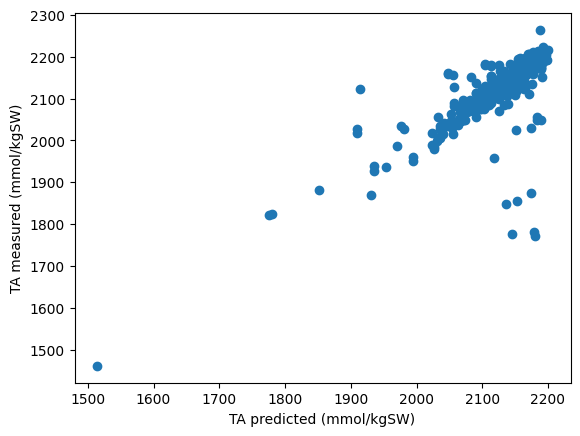

In [61]:
# use the lofi model to predict TA from salinity in a new column
predicted_ta = ta['SAL (PSU)'].apply(lofi)

# Plot the lofi model against the hifi data
plt.scatter(predicted_ta, ta['TA in (mmol/kgSW)'])
plt.xlabel('TA predicted (mmol/kgSW)')
plt.ylabel('TA measured (mmol/kgSW)')

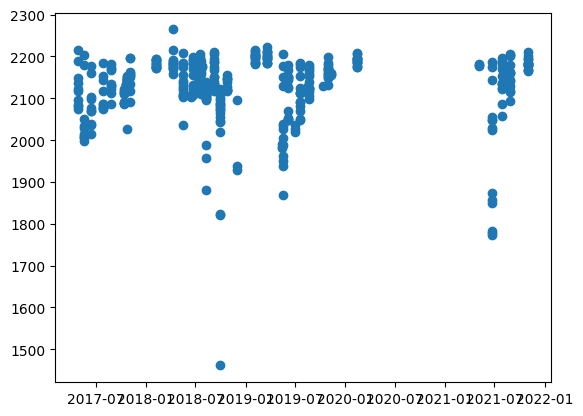

In [16]:
# Plot total alkalinity vs time
plt.scatter(ta['PROF_DATE_TIME_LOCAL'], ta['TA in (mmol/kgSW)'])

In [62]:
# Combine lofi_pos and hifi_pos into a single array
pos = np.concatenate((lofi_pos, hifi_pos))
#pos = hifi_pos

# Combine lofi_ta and hifi_ta into a single array
ta = np.concatenate((lofi_ta, hifi_ta))
#ta = hifi_ta

In [24]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel
from gpytorch.means import ConstantMean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
train_x = torch.from_numpy(pos).float()
train_y = torch.from_numpy(ta).float()

train_x.shape, train_y.shape

(torch.Size([4054, 6]), torch.Size([4054]))

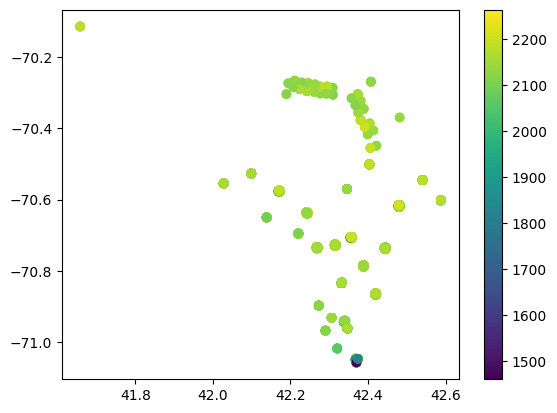

In [64]:
# Plot the 3d x values vs the 1d y values
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y)
plt.colorbar()

# Training

In [65]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Training Hifi

In [34]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [66]:
training_iter = 200
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/200 - Loss: 127129.766   lengthscale: 0.693   noise: 0.693
Iter 2/200 - Loss: 40611.035   lengthscale: 0.974   noise: 0.974
Iter 3/200 - Loss: 18414.850   lengthscale: 1.262   noise: 1.238
Iter 4/200 - Loss: 8637.761   lengthscale: 1.538   noise: 1.477
Iter 5/200 - Loss: 5696.661   lengthscale: 1.791   noise: 1.697
Iter 6/200 - Loss: 3133.379   lengthscale: 2.022   noise: 1.897
Iter 7/200 - Loss: 2987.299   lengthscale: 2.230   noise: 2.081
Iter 8/200 - Loss: 2358.200   lengthscale: 2.418   noise: 2.249
Iter 9/200 - Loss: 1989.719   lengthscale: 2.588   noise: 2.404
Iter 10/200 - Loss: 1337.787   lengthscale: 2.742   noise: 2.546
Iter 11/200 - Loss: 1533.842   lengthscale: 2.882   noise: 2.678
Iter 12/200 - Loss: 1384.751   lengthscale: 3.008   noise: 2.800
Iter 13/200 - Loss: 1253.204   lengthscale: 3.123   noise: 2.912
Iter 14/200 - Loss: 1132.100   lengthscale: 3.228   noise: 3.016
Iter 15/200 - Loss: 1101.663   lengthscale: 3.324   noise: 3.112
Iter 16/200 - Loss: 1053.529  

# Validation using F05

In [50]:
f05 = f05[(f05['TA in (mmol/kgSW)'].notnull()) & (f05['DEPTH (m)'] > 19)]
dates = f05['PROF_DATE_TIME_LOCAL'].values
tas = f05['TA in (mmol/kgSW)'].values

In [51]:
f05['DEPTH (m)']

137    25.73
193    25.85
250    26.10
549    26.66
552    19.66
605    23.95
661    24.29
747    23.90
Name: DEPTH (m), dtype: float64

In [52]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Max date
    #max_date = dates.max()
    # Min date
    #min_date = dates.min()
    # Number of days
    #num_days = (max_date - min_date).days
    # Sample the ta data every day

    test_x = torch.from_numpy(f05[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values).float()
    observed_pred = likelihood(model(test_x))

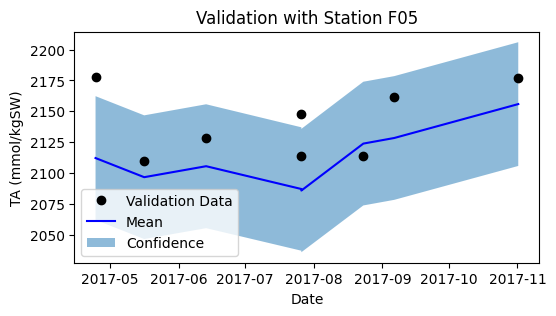

In [53]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Plot training data as black stars
    ax.plot(dates, tas, 'ko')

    # Max date
    max_date = dates.max()

    # Min date
    min_date = dates.min()

    # Date for every day in the range
    dates2 = np.arange(min_date, max_date, dtype='datetime64[D]')
    dates2 = dates.astype('datetime64[ns]')
    
    # Plot predictive means as blue line
    ax.plot(dates, observed_pred.mean.numpy(), 'b')

    # Shade between the lower and upper confidence bounds
    ax.fill_between(dates, lower.numpy(), upper.numpy(), alpha=0.5)

    # Set x axis label
    ax.set_xlabel('Date')

    # Set y axis label
    ax.set_ylabel('TA (mmol/kgSW)')

    ax.legend(['Validation Data', 'Mean', 'Confidence'])

    # Title
    ax.set_title('Validation with Station F05')